Setting Library

In [148]:
#Data Prrocessing
import pandas as pd
import datetime as dt
import numpy as np

#API
import vnstock
from vnstock import *

#Visualization
import matplotlib.pyplot as plt

#Predictions
import tensorflow as tf
tf.config.list_physical_devices('GPU') #GPU device
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras import optimizers

Load data

In [149]:
#Company list
companies = []
fhandle = open("Data\companylist.txt","r")
order = 0
for line in fhandle.readlines():
    company = line.strip()
    order += 1
    print(f"{order}.{company}'s stock")

1.FPT's stock
2.CTG's stock
3.LCG's stock
4.HAG's stock


In [150]:
company = 'FPT'
df = pd.read_csv(f"Data\Raw\{company}.csv", delimiter = ",", encoding="utf-8")
df

,Unnamed: 0,Open,High,Low,Close,Volume,TradingDate
0,0,14129.0,14129.0,13246.0,14129.0,2830,2008-12-22
1,1,14718.0,14718.0,14718.0,14718.0,3010,2008-12-23
2,2,15454.0,15454.0,15454.0,15454.0,1000,2008-12-24
3,3,16190.0,16190.0,16190.0,16190.0,156010,2008-12-25
4,4,16924.0,16925.0,16484.0,16925.0,304910,2008-12-26
...,...,...,...,...,...,...,...
3518,3518,9580.0,9650.0,9410.0,9410.0,14316394,2023-01-30
3519,3519,9410.0,9520.0,9220.0,9520.0,16470526,2023-01-31
3520,3520,9600.0,9640.0,8900.0,8910.0,19485323,2023-02-01
3521,3521,9000.0,9000.0,8530.0,8550.0,21855201,2023-02-02


Preprocessing data

In [37]:
#Format data
df['TradingDate'] = pd.to_datetime(df.TradingDate, format = "%Y/%m/%d")

In [201]:
#* Candlesticks
#* Median
#* var
#* SMV
#* SD
#* sem
#* RSI 


#Candlesticks
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']

#Labels
MA1 = 7
MA2 = 14
MA3 = 21
MA4 = 28

df['AR'] = df['H-L']/df['O-C']
#Median
df[f'ME_{MA1}'] = df['Close'].rolling(window = MA1).median()
df[f'ME_{MA2}'] = df['Close'].rolling(window = MA2).median()
df[f'ME_{MA3}'] = df['Close'].rolling(window = MA3).median()
df[f'ME_{MA4}'] = df['Close'].rolling(window = MA4).median()
#Rank 
df[f'RANK_{MA1}'] = df['Close'].rolling(window = MA1).rank()
df[f'RANK_{MA2}'] = df['Close'].rolling(window = MA2).rank()
df[f'RANK_{MA3}'] = df['Close'].rolling(window = MA3).rank()
df[f'RANK_{MA4}'] = df['Close'].rolling(window = MA4).rank()

#Var
df[f'VAR_{MA1}'] = df['Close'].rolling(window = MA1).var()
df[f'VAR_{MA2}'] = df['Close'].rolling(window = MA2).var()
df[f'VAR_{MA3}'] = df['Close'].rolling(window = MA3).var()
df[f'VAR_{MA4}'] = df['Close'].rolling(window = MA4).var()

#Simple moving average
df[f'SMA_{MA1}'] = df['Close'].rolling(window = MA1).mean()
df[f'SMA_{MA2}'] = df['Close'].rolling(window = MA2).mean()
df[f'SMA_{MA3}'] = df['Close'].rolling(window = MA3).mean()
df[f'SMA_{MA4}'] = df['Close'].rolling(window = MA4).mean()

#Standard deviation
df[f'SD_{MA1}'] = df['Close'].rolling(window = MA1).std()
df[f'SD_{MA2}'] = df['Close'].rolling(window = MA2).std()
df[f'SD_{MA3}'] = df['Close'].rolling(window = MA3).std()
df[f'SD_{MA4}'] = df['Close'].rolling(window = MA4).std()

#Skewness
df[f'Ske_{MA1}'] = df['Close'].rolling(window = MA1).skew()
df[f'Ske_{MA2}'] = df['Close'].rolling(window = MA2).skew()
df[f'Ske_{MA3}'] = df['Close'].rolling(window = MA3).skew()
df[f'Ske_{MA4}'] = df['Close'].rolling(window = MA4).skew()

#Kurtosis
df[f'Kur_{MA1}'] = df['Close'].rolling(window = MA1).kurt()
df[f'Kur_{MA2}'] = df['Close'].rolling(window = MA2).kurt()
df[f'Kur_{MA3}'] = df['Close'].rolling(window = MA3).kurt()
df[f'Kur_{MA4}'] = df['Close'].rolling(window = MA4).kurt()

df[df.replace([np.inf, -np.inf], np.nan).notnull().all(axis = 1)]
#Drop missing data
df.dropna(inplace = True)


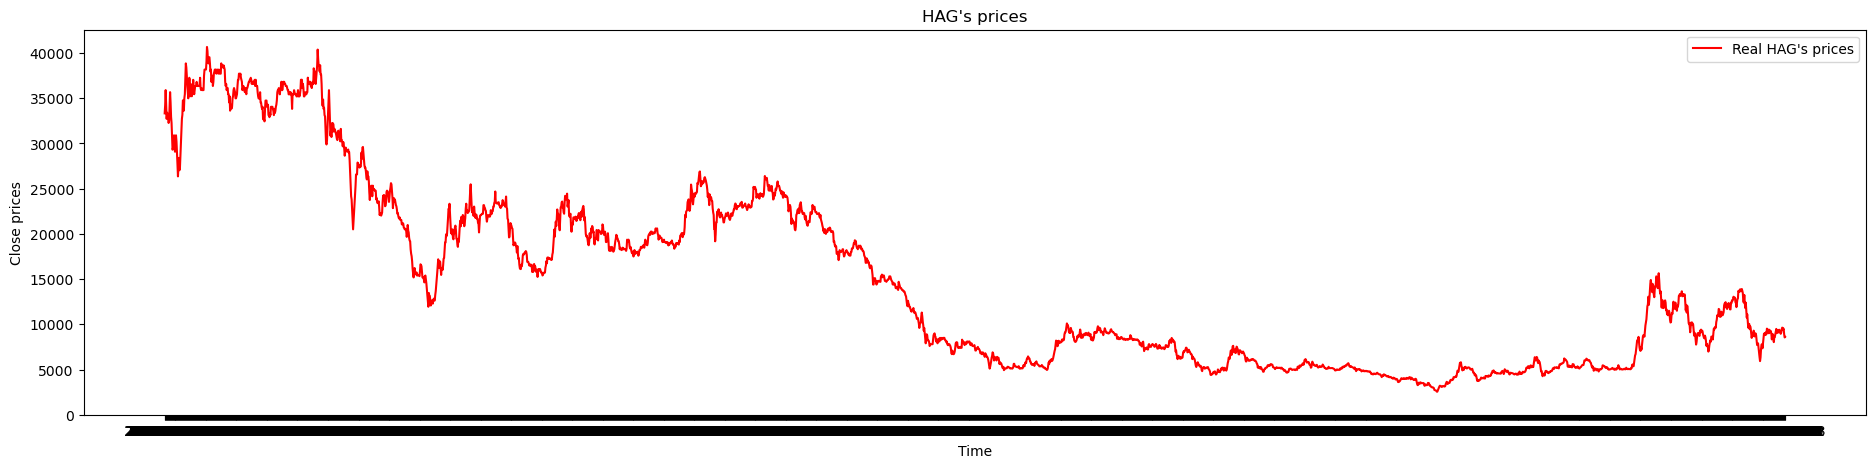

In [193]:
#Visualization
real_price = pd.DataFrame(df, columns = ['TradingDate', 'Close'])
real_price.index = real_price.TradingDate
real_price.drop('TradingDate', axis = 1, inplace = True)
plt.figure(figsize = (23,5))
plt.plot(real_price['Close'], color = "red", label = f"Real {company}'s prices")
plt.title(f"{company}'s prices")
plt.xlabel("Time")
plt.ylabel("Close prices")
plt.ylim(bottom = 0)
plt.legend() #Notices
plt.show()

In [194]:
#Exporting data
df.to_csv(f"Data\Prepaired\{company}pre.csv", encoding = "utf-8")

Processing Data

In [195]:
#Set domain
scaler_x = MinMaxScaler(feature_range = (0, 1))
scaler_y = MinMaxScaler(feature_range = (0, 1))

In [196]:
#Fit data
cols_x = ['H-L', 'O-C', 'Volume', f'ME_{MA1}', f'ME_{MA2}', f'ME_{MA3}', f'ME_{MA4}', f'VAR_{MA1}', f'VAR_{MA2}', f'VAR_{MA3}', f'VAR_{MA4}', f'RANK_{MA1}', f'RANK_{MA2}', f'RANK_{MA3}', f'RANK_{MA4}', f'SMA_{MA1}', f'SMA_{MA2}', f'SMA_{MA3}', f'SMA_{MA4}', f'SD_{MA1}' ,f'SD_{MA2}', f'SD_{MA3}', f'SD_{MA4}', f'Ske_{MA1}', f'Ske_{MA2}', f'Ske_{MA3}', f'Ske_{MA4}', f'Kur_{MA1}', f'Kur_{MA2}', f'Kur_{MA3}', f'Kur_{MA4}',] #Variables for training
cols_y = ['Close'] #Variable for predict
scaled_data_x = scaler_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x))) 
scaled_data_y = scaler_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

In [180]:
df.head()

,Unnamed: 0,Open,High,Low,Close,Volume,TradingDate,H-L,O-C,ME_7,...,RANK_21,RANK_28,VAR_7,VAR_14,VAR_21,VAR_28,Kur_7,Kur_14,Kur_21,Kur_28
135,135,22421.0,22423.0,21514.0,21665.0,592130,2009-07-10,909.0,756.0,21211.0,...,14.5,17.5,457032.285714,535690.747253,556469.661905,763345.136243,-0.444267,-0.629693,-0.599498,-0.302057
136,136,22421.0,22423.0,21665.0,21817.0,1351180,2009-07-13,758.0,604.0,21362.0,...,16.5,18.5,288665.285714,539766.263736,546993.333333,628338.596561,0.872040,-0.189587,-0.552574,-0.377128
137,137,21663.0,21665.0,21211.0,21514.0,730650,2009-07-14,454.0,149.0,21514.0,...,12.0,14.0,112589.809524,539766.263736,543068.761905,582208.850529,-0.421793,-0.189587,-0.418524,-0.006704
138,138,21815.0,21817.0,21362.0,21362.0,529960,2009-07-15,455.0,453.0,21514.0,...,9.5,11.5,112589.809524,513633.763736,491825.333333,580423.015873,-0.421793,-0.092039,0.206952,0.026584
139,139,21512.0,21514.0,20908.0,21211.0,734750,2009-07-16,606.0,301.0,21514.0,...,7.0,9.5,112589.809524,465115.054945,491825.333333,555998.148148,-0.421793,0.113163,0.206952,0.167394


In [197]:
#Training seq X and output value Y
pre_day = 90
x_total = [] # Variables today
y_total = [] #Close price tomorrow
for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i - pre_day : i])
    y_total.append(scaled_data_y[i])

In [202]:
#Set test
test_size = 60

#Traning set
x_train = np.array(x_total[:len(x_total)-test_size]) #tranning set (0, 30)
y_train = np.array(y_total[:len(y_total)-test_size]) #taget tranning set

#Predicted set
x_test = np.array(x_total[len(x_total)-test_size:]) #predicted set (31,...)
y_test = np.array(y_total[len(y_total)-test_size:]) #taget predicted set

#Structure of tranning data
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(3145, 90, 31) (3145, 1) (60, 90, 31) (60, 1)


Build Model

In [220]:
#Layers
model = Sequential()
cells = 180
model.add(LSTM(units = cells, return_sequences = True, activation='tanh', recurrent_activation='sigmoid', input_shape = (x_train.shape[1], x_train.shape[2]))) #input traning date and predicting date 
model.add(Dropout(0.1))
model.add(LSTM(units = cells))
model.add(Dropout(0.1))
model.add(Dense(units = len(cols_y)))

In [228]:
#Config tranning
#optimizer=optimizers.RMSprop()
model.compile(optimizer = optimizers.RMSprop(), loss = 'mse', metrics = ['accuracy']) #Optimizer, loss
history = model.fit(x_train, y_train, epochs = 10, batch_size = 5, use_multiprocessing = True, validation_split=0.2, shuffle=True)#Fit input to taget

Epoch 1/10
504/504 [==============================] - ETA: 0s - loss: 4.6609e-04 - accuracy: 7.9491e-04

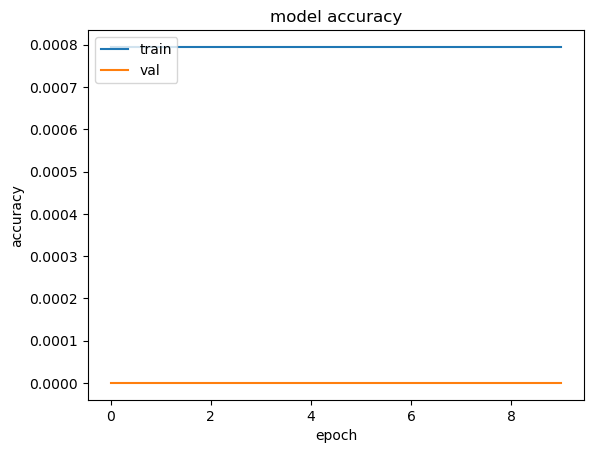

In [227]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

2/2 [==============================] - 1s 11ms/step


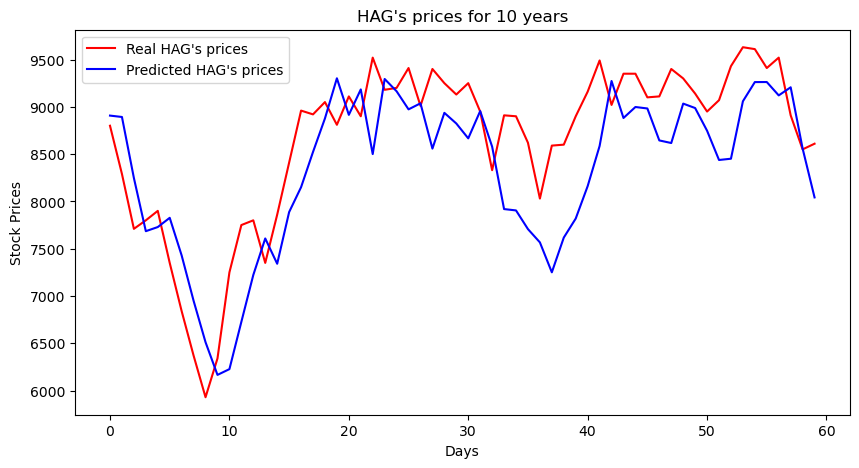

In [222]:
#Config real price
real_price = df[len(df)-test_size:]['Close'].values.reshape(-1, 1)
real_price = np.array(real_price)
real_price = real_price.reshape(real_price.shape[0], 1)

#Config predicted price
predict_prices = model.predict(x_test)
predict_prices = scaler_y.inverse_transform(predict_prices)

#Predicted days
plt.figure(figsize = (10,5))
plt.plot(real_price, color = "red", label = f"Real {company}'s prices")
plt.plot(predict_prices, color = "blue", label = f"Predicted {company}'s prices")
plt.title(f"{company}'s prices for 10 years")
plt.xlabel("Days")
plt.ylabel("Stock Prices")
plt.legend()
plt.show()

In [50]:
#Save model
from keras.models import save_model

save_model(model, f"Model\{company}.h5", include_optimizer = True)

# Deploy product

Load model

In [ ]:
#Load model
from keras.models import load_model

model = load_model(f"Model\{company}.h5")